# Data Exploration and Pre-processing

In [1]:
#necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#load age_gender.csv and observe it
data = pd.read_csv('/kaggle/input/age-gender/age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


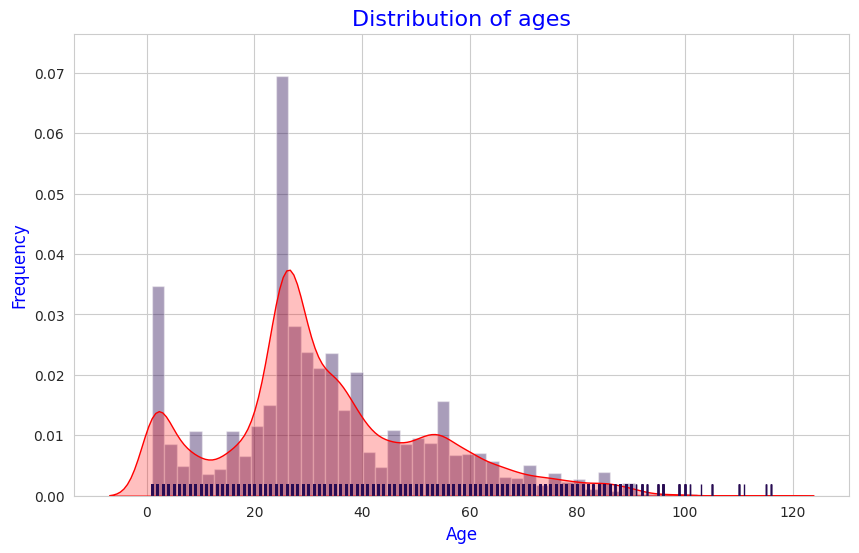

In [3]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(data['age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

In [4]:
import numpy as np
import os
from PIL import Image

# Create a directory to save the images
img_directory = "/mnt/data/images/"
if not os.path.exists(img_directory):
    os.makedirs(img_directory)

# Convert the pixels string to actual images and save them in the directory
for index, row in data.iterrows():
    # Convert the pixel string to a numpy array
    pixels = np.array(row['pixels'].split(), dtype=np.uint8)
    
    # Reshape the array to form the image
    img = Image.fromarray(pixels.reshape(48, 48))
    
    # Save the image with its name from the dataframe
    img_path = os.path.join(img_directory, row['img_name'])
    img.save(img_path)

# Display the path of the first few saved images for verification
saved_img_paths = [os.path.join(img_directory, img_name) for img_name in data['img_name'].head()]
saved_img_paths


['/mnt/data/images/20161219203650636.jpg.chip.jpg',
 '/mnt/data/images/20161219222752047.jpg.chip.jpg',
 '/mnt/data/images/20161219222832191.jpg.chip.jpg',
 '/mnt/data/images/20161220144911423.jpg.chip.jpg',
 '/mnt/data/images/20161220144914327.jpg.chip.jpg']

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator object for training dataset with rescaling
train_datagen = ImageDataGenerator(
    rescale=1 / 255
)

# Use flow_from_dataframe method to load images from the directory and labels from the dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=data,
    directory=img_directory,
    x_col="img_name",
    y_col="age",
    class_mode="raw",
    target_size=(224, 224),  # the original image size from the dataset
    batch_size=32,
    seed=12345
)


Found 23705 validated image filenames.


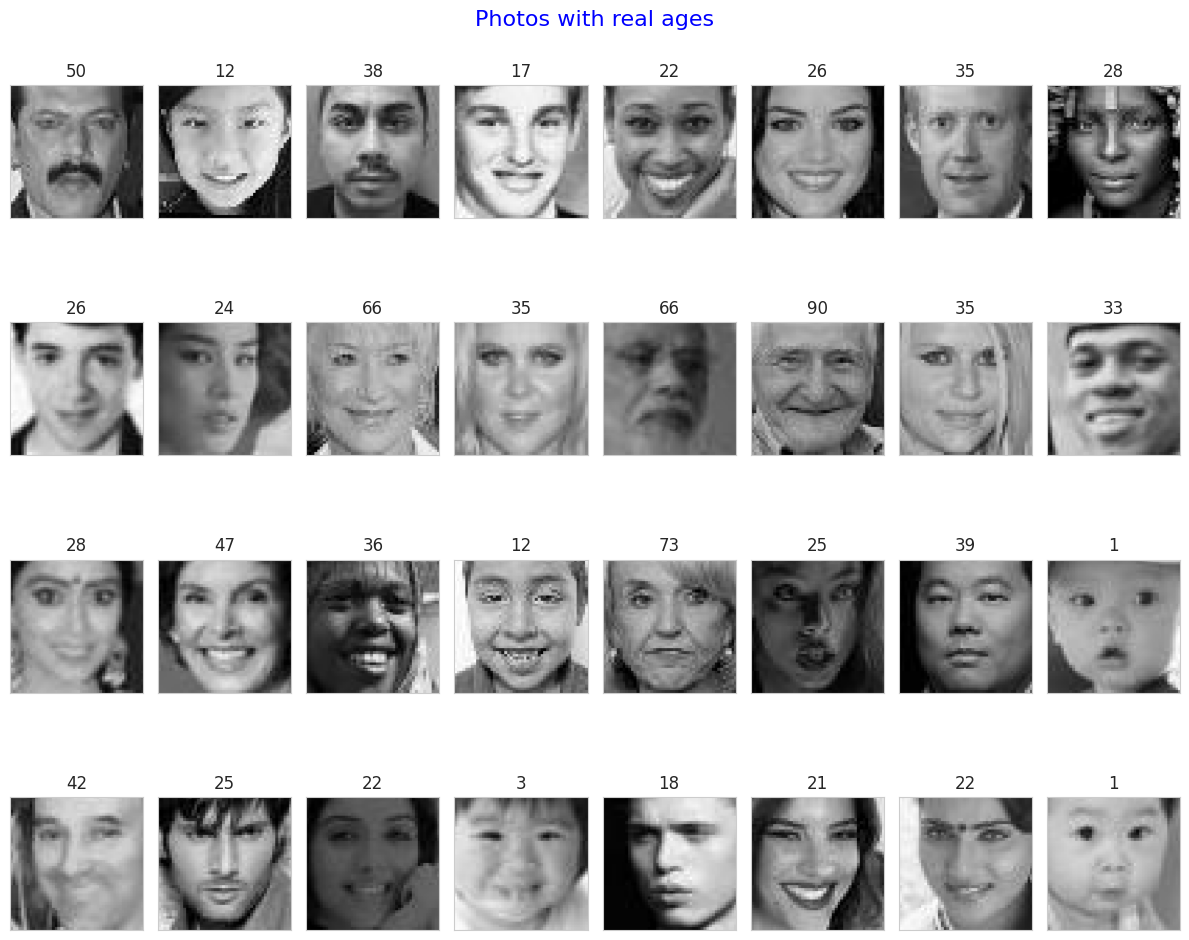

In [6]:
# Get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# Display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

# Model Development

In [29]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(os.path.join(path, 'age_gender.csv'))
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/mnt/data/images/',  
        x_col='img_name',
        y_col='age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(os.path.join(path, 'age_gender.csv'))
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/mnt/data/images/',  
        x_col='img_name',
        y_col='age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    """
    It defines the model
    """
    # ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    # Adding custom layers
    # Optimal dropout rate found in hyperparameter tuning
    model.add(Dropout(0.2)) 
    
    model.add(GlobalAveragePooling2D())
    
    # final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    
    # Optimal learning rate found in hyperparameter tuning
    optimizer = Adam(lr=0.00002)
    
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    history = model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
                        epochs=epochs, steps_per_epoch=steps_per_epoch, 
                        validation_steps=validation_steps, verbose=2)
    
    return model, history


# Training

In [30]:
#assign data directory
path = '/kaggle/input/age-gender/'

In [31]:
#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)


# build a model
model_instance = create_model(input_shape = (224, 224, 3))

Found 17779 validated image filenames.
Found 5926 validated image filenames.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


In [32]:
# train the model
model, history = train_model(model_instance, train_data, test_data)

Epoch 1/20


2023-09-24 09:30:44.635796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


556/556 - 162s - loss: 10.1720 - mae: 10.1720 - val_loss: 10.4251 - val_mae: 10.4251 - 162s/epoch - 291ms/step
Epoch 2/20
556/556 - 125s - loss: 8.2213 - mae: 8.2213 - val_loss: 6.3859 - val_mae: 6.3859 - 125s/epoch - 224ms/step
Epoch 3/20
556/556 - 125s - loss: 7.4600 - mae: 7.4600 - val_loss: 13.0966 - val_mae: 13.0966 - 125s/epoch - 224ms/step
Epoch 4/20
556/556 - 125s - loss: 7.0385 - mae: 7.0385 - val_loss: 12.7196 - val_mae: 12.7196 - 125s/epoch - 225ms/step
Epoch 5/20
556/556 - 125s - loss: 6.6159 - mae: 6.6159 - val_loss: 5.9642 - val_mae: 5.9642 - 125s/epoch - 224ms/step
Epoch 6/20
556/556 - 125s - loss: 6.2549 - mae: 6.2549 - val_loss: 7.6635 - val_mae: 7.6635 - 125s/epoch - 224ms/step
Epoch 7/20
556/556 - 125s - loss: 5.8873 - mae: 5.8873 - val_loss: 7.4446 - val_mae: 7.4446 - 125s/epoch - 224ms/step
Epoch 8/20
556/556 - 125s - loss: 5.6129 - mae: 5.6129 - val_loss: 8.6022 - val_mae: 8.6022 - 125s/epoch - 224ms/step
Epoch 9/20
556/556 - 125s - loss: 5.2858 - mae: 5.2858 - va

# Evaluation

1/1 [==============================] - 0s 23ms/step
Original Age: 26
Predicted Age: 26


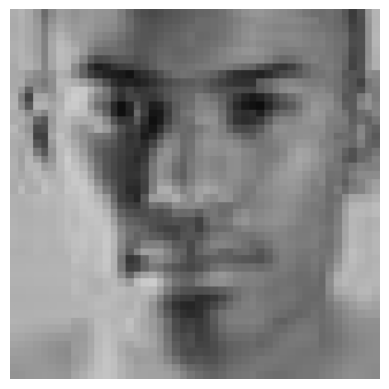

In [79]:
import matplotlib.pyplot as plt

# Get a specific batch from the training data
batch = next(train_data)

# Select an image and its label from the batch
sample_image = batch[0][0]  # 0th image from the batch
sample_label = batch[1][0]  # Corresponding age label

# Make a prediction using the model
pred_age = model.predict(sample_image.reshape(1, 224, 224, 3))[0][0]  # Reshaping to match the model's expected input shape

# Display the result
print("Original Age:", sample_label)
print("Predicted Age:", round(pred_age))

plt.axis('off')
plt.imshow(sample_image.reshape(224, 224, 3))
plt.show()


In [39]:
# Evaluate the model on the test data
loss = model.evaluate(test_data, verbose=1)

# Display the MAE
print(f"Mean Absolute Error (MAE) on Test Data: {loss[1]}")


186/186 [==============================] - 12s 64ms/step - loss: 4.9438 - mae: 4.9438
Mean Absolute Error (MAE) on Test Data: 4.943795204162598


In [40]:
# Obtain Predictions from the Model
y_pred = model.predict(test_data)

# Get True Age Labels
y_true = test_data.labels

# Define the percentage function
def within_percentage(y_true, y_pred, t= 20):
    correct_predictions = np.sum(np.abs(y_true - y_pred.squeeze()) <= t)
    total_predictions = len(y_true)
    accuracy_percentage = (correct_predictions / total_predictions) * 100
    return accuracy_percentage

# Compute and print the Accuracy Percentage
percentage = within_percentage(y_true, y_pred)
print(f"Accuracy {percentage:.2f}%")


186/186 [==============================] - 12s 61ms/step
Accuracy 74.91%


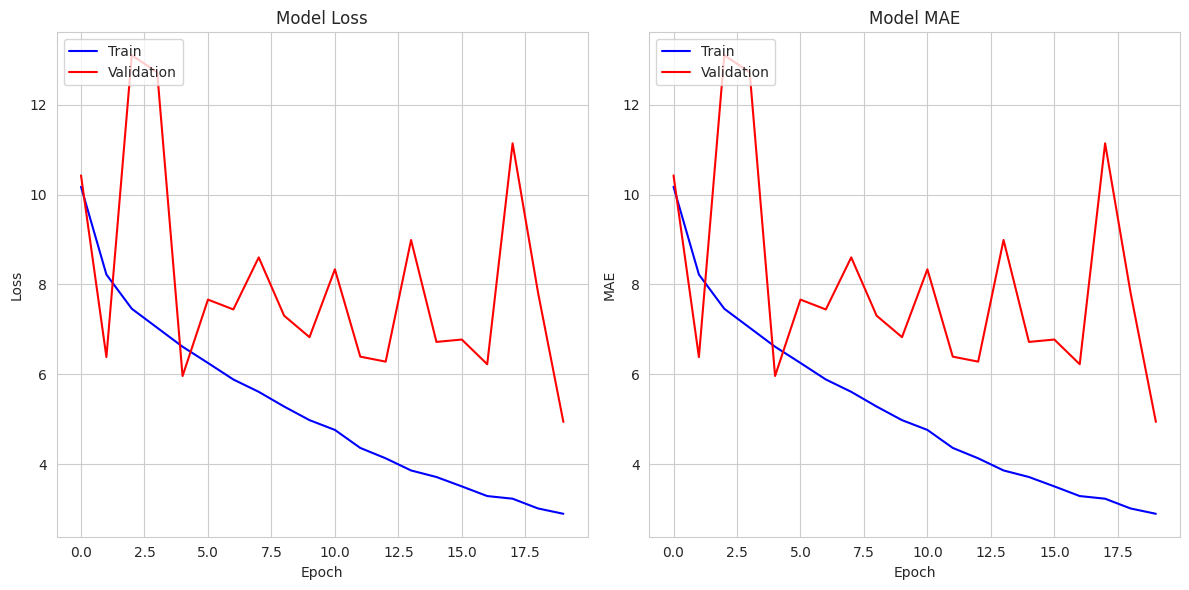

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# MAE plot (if you have other metrics, you can plot them similarly)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], color='blue', label='Train')
plt.plot(history.history['val_mae'], color='red', label='Validation')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Hyperparameter tuning

In [15]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch
import pandas as pd
import os

In [ ]:
# Function to load train data
def load_train(path):
    labels = pd.read_csv(os.path.join(path, 'age_gender.csv'))
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/mnt/data/images/',  
        x_col='img_name',
        y_col='age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

# Function to load test data
def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'age_gender.csv'))
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/mnt/data/images/',  
        x_col='img_name',
        y_col='age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

# Hypermodel definition for Keras Tuner
class MyHyperModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        backbone = ResNet50(input_shape=self.input_shape, weights='imagenet', include_top=False)
        model = Sequential()
        model.add(backbone)
        
        model.add(Dropout(rate=hp.Float('dropout', 0.1, 0.5, step=0.1)))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu'))
        
        model.compile(optimizer=Adam(lr=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                      loss='mae',
                      metrics=['mae'])
        
        return model

# Assign data directory
path = '/kaggle/input/age-gender/'
input_shape = (224, 224, 3)

# Load train and test data
train_data = load_train(path)
test_data = load_test(path)

# Create hypermodel and tuner
hypermodel = MyHyperModel(input_shape)
tuner = RandomSearch(
    hypermodel.build,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='age_prediction'
)

# Hyperparameter search
tuner.search(train_data,
             epochs=10,
             validation_data=test_data)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 8 Complete [01h 23m 25s]
val_mae: 5.495758771896362

Best val_mae So Far: 4.671244859695435
Total elapsed time: 11h 07m 06s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
0.3               |0.2               |dropout
0.0044559         |0.00033606        |learning_rate

Epoch 1/10


2023-09-22 05:19:55.709236: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


556/556 [==============================] - 280s 429ms/step - loss: 10.1741 - mae: 10.1741 - val_loss: 8.9247 - val_mae: 8.9247
Epoch 2/10
556/556 [==============================] - 240s 432ms/step - loss: 8.2153 - mae: 8.2153 - val_loss: 8.0336 - val_mae: 8.0336
Epoch 3/10
556/556 [==============================] - 240s 431ms/step - loss: 7.6330 - mae: 7.6330 - val_loss: 7.2493 - val_mae: 7.2493
Epoch 4/10
556/556 [==============================] - 240s 431ms/step - loss: 7.1315 - mae: 7.1315 - val_loss: 7.1614 - val_mae: 7.1614
Epoch 5/10
556/556 [==============================] - 240s 431ms/step - loss: 6.6048 - mae: 6.6048 - val_loss: 5.5836 - val_mae: 5.5836
Epoch 6/10
556/556 [==============================] - 238s 428ms/step - loss: 6.2940 - mae: 6.2940 - val_loss: 6.6674 - val_mae: 6.6674
Epoch 7/10
556/556 [==============================] - 238s 428ms/step - loss: 6.0928 - mae: 6.0928 - val_loss: 6.6302 - val_mae: 6.6302
Epoch 8/10
556/556 [==============================] - 238